In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import glob, os, re, random

from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from itertools import groupby
from operator import itemgetter


from fuzzywuzzy import  fuzz, process

from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


After a conversation with a friend experienced in medical science, she pointed out that there is a combination that can weaken a patient and sometimes triggering symptoms of diabetes mellitus. In this notebook, I am going to text mine medications with the goal to find combinations that let to diabetes in the data.

The process consists in:
1. Convert medication names into document. Each document will be a list of words
2. Build a vocabulary: This is hash table of all unique terms found in all documents
3. Calculate how important each term is for each document. We will use [tf-idf](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
4. Remove noisy terms. Noisy terms are those with high tf-idf in as many document as possible. Keeping in mind that the tfidf is value between 0 and 1, we can sum tf-idfs for each term in all document and set thresholds accordingly. Noisy terms will be added to the list of stop_words
5. With the right vocabulary in hands (initial vocabulary without noisy terms), we will build a binary table with index being PatientHuid and Columns being terms in the dictionary. Each cell value will be 1 if the term has been part of medications ever prescribed to the patient of interest.

Resources:
- http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [2]:
filenames = glob.glob('data/trainingSet/*.csv')
data = {'trainingSet':{},'testSet':{}}
for filename in filenames:
    k = os.path.basename(filename)[:-4].replace('training_','')
    data['trainingSet'][k] = pd.read_csv(filename)
    data['testSet'][k] = pd.read_csv(filename.replace('training','test'))
    print k

SyncCondition
SyncSmokingStatus
SyncAllergy
SyncDiagnosis
SyncImmunization
SyncLabObservation
SyncLabPanel
SyncLabResult
SyncMedication
SyncPatient
SyncPatientCondition
SyncPatientSmokingStatus
SyncPrescription
SyncTranscript
SyncTranscriptAllergy
SyncTranscriptDiagnosis
SyncTranscriptMedication


In [206]:
df0 = data['trainingSet']['SyncPatient'].copy()
df0.index = df0.PatientGuid
df0 = df0.drop('PatientGuid',axis=1).sort_index()

df1 = data['trainingSet']['SyncMedication'].copy()
df1 = df1[~df1.MedicationName.isnull()]
patient_medication = df1[['PatientGuid','MedicationName']]
patient_medication.MedicationName+=' '
patient_medication = patient_medication.groupby('PatientGuid').sum().sort_index()

In [207]:
for col in df1.columns:
    print col, '\t',df1[col].unique().shape[0]

MedicationGuid 	44382
PatientGuid 	9836
NdcCode 	9146
MedicationName 	2552
MedicationStrength 	893
Schedule 	5
DiagnosisGuid 	29293
UserGuid 	849


### data cleaning
- remove all characters which are not alphatic
- remove buzz words
- find similarity between words. Some medical terms can be from same family, so I want these to be grouped together

In [208]:
def clean_text(txt,stop_words):
    wnl = WordNetLemmatizer()
    psm = PorterStemmer()
    # make sure in put is of type str
    if type(txt) is not str:
        txt = str(txt)
    #lower case
    txt = txt.lower()
    #remove non-alphabetic characters
    txt = re.sub("[^\s\w]"," ",txt).split(" ")
    #txt = [str(psm.stem(wnl.lemmatize(w.strip()))) for w in txt]
    #remove stop words
    txt = filter(lambda w:not (w in stop_words),txt)
    txt = ' '.join(txt)
    return txt
    
    

process time: 0:00:01.521512


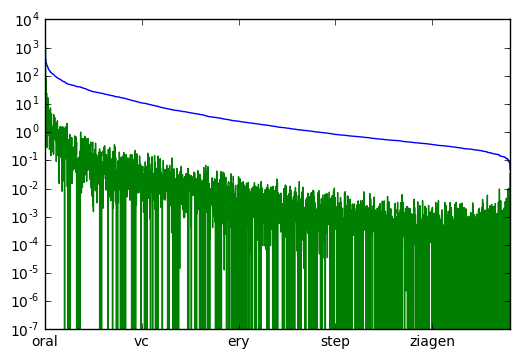

In [212]:
tic = dt.datetime.now()
stop_words_ = [' ','','oral','tablet','capsule','release','topical','extended','nasal','inhalation',
              'with','delayed','coated','enteric','aerosol','spray','metoprotol','solution','cream',
              'sodium','syrup','d','adapter','tab','tabs','10','100','104','disintegrating','acid','intravenous',
             '1000','11','12','120','12d','13','15','150','16','1a','1b','1x','20','200','2011','2012','21',
              '23','24','24d','25','28','30','300','325','3350','35','40','400','50','500','60','600','625',
              '2a','64','650','750','75','80','81','900','acids','and','at','device','di','dr','easy','ii','in',
              'iv','mg','non','of','oil','pack','packet','packets','poly','top']
stop_words = [' ','',
              'with', '10','100','104',
             '1000','11','12','120','12d','13','15','150','16','1a','1b','1x','20','200','2011','2012','21',
              '23','24','24d','25','28','30','300','325','3350','35','40','400','50','500','60','600','625',
              '2a','64','650','750','75','80','81','900','and','at','ii','in',
              'iv','mg','non','of','poly','top']
medText = df1.MedicationName.apply(lambda w:clean_text(w,stop_words))
medText = patient_medication.MedicationName.apply(lambda w:clean_text(w,stop_words))
corpus = medText.values.tolist()
tf = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words, ngram_range=(1,1))
tfidf_matrix = tf.fit_transform(corpus)
medications_tfidf = pd.DataFrame(tfidf_matrix.todense(),
                                 index = patient_medication.index,
                                 columns = sorted(tf.vocabulary_),)
print "process time:", dt.datetime.now() - tic

tfidf_agg = medications_tfidf.sum().sort_values(ascending=False)
d_tfidf_agg = -(tfidf_agg - tfidf_agg.shift())#.sort_values()
tfidf_agg.plot()
d_tfidf_agg.plot()
plt.yscale('log')
plt.show()


In [213]:
stop_words+=tfidf_agg[tfidf_agg>=10].index.tolist()
medText = patient_medication.MedicationName.apply(lambda w:clean_text(w,stop_words))
corpus = medText.values.tolist()
tf = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words, ngram_range=(1,1))
tfidf_matrix = tf.fit_transform(corpus)
medications_tfidf = pd.DataFrame(tfidf_matrix.todense(),
                                 index = patient_medication.index,
                                 columns = sorted(tf.vocabulary_),)
medications_tfidf = 1*(medications_tfidf>0)
medications_tfidf['DMIndicator'] = df0.DMIndicator

### Modeling

,abacavir,absorbase,acamprosate,acarbose,accolate,accupril,accuretic,aceon,acetasol,acetazolamide,...,zotex,zovia,zyban,zydis,zyflo,zyloprim,zymar,zyprexa,zyvox,DMIndicator
PatientGuid,,,,,,,,,,,,,,,,,,,,,
00023761-9D8D-445B-874C-2424CC7CF620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000B4862-7CE7-4EC5-8043-A97FCD74BD78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002667F4-B9A3-4DE2-875F-8034DD637865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0029BBC8-7C22-4444-9F44-87BEF05FE033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003CEE1F-5BF5-4171-9284-F5464EC12D41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004382BD-E31F-4091-8DE5-E86A59D70C2D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004AACFF-5D67-49B3-81F4-883A72A2AB97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
medications_tfidf

,abacavir,absorbase,acamprosate,acarbose,accolate,accupril,accuretic,aceon,acetasol,acetazolamide,...,zostrix,zotex,zovia,zyban,zydis,zyflo,zyloprim,zymar,zyprexa,zyvox
PatientGuid,,,,,,,,,,,,,,,,,,,,,
00023761-9D8D-445B-874C-2424CC7CF620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000B4862-7CE7-4EC5-8043-A97FCD74BD78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002667F4-B9A3-4DE2-875F-8034DD637865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0029BBC8-7C22-4444-9F44-87BEF05FE033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003CEE1F-5BF5-4171-9284-F5464EC12D41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004382BD-E31F-4091-8DE5-E86A59D70C2D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004AACFF-5D67-49B3-81F4-883A72A2AB97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
